# Deffaunt-Weisbuch Model with Heterogeneous Activation Probability
## Author: Grace Li
## Created On: 11/13/2021

This python code plots the aggregated graph-level results using the outputs of the MatfileConsolidator.ipynb code.

In [1]:
# import required packages  

import numpy as np
import pandas as pd
from scipy import io, stats
import os
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import time as time
import igraph as igraph


#this line is to make sure the animation writer can find the ffmpeg executable if we want to generate an animation
plt.rcParams['animation.ffmpeg_path'] = r'/home/graceli/.local/lib/ffmpeg-4.3.2-amd64-static/ffmpeg'


In [2]:
# Import our own DW module
import sys
sys.path.append('..') #look one directory above
import DW as DW

In [3]:
#name of experiment folder
graph_type = "complete"
distribution = "Constant"
n = 500

#savefolder name for experiment
experiment = graph_type + str(n) + "/" + distribution

In [4]:
#specify confidence radii ds and compromise parameters mus

'''
NOTE: THE CONFIDENCE RADIUS IS CALLED d HERE, BUT c IN THE PAPER
NOTE: THE COMPROMISE PARAMETER IS CALLED mu HERE, BUT m IN THE PAPER
'''

#confidence radius
# ds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.7, 0.9]
ds = [0.1, 0.2, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.35, 0.4, 0.5]
ds = np.flip(ds) #flip ds so that heatmaps are ordered properly

#compromise parameter
# mus = [0.3, 0.5]
mus = [0.1, 0.3, 0.5]

#Define which d and mu combos we want histograms of
hist_ds = [0.1, 0.3, 0.5]
# hist_ds = [0.1, 0.2, 0.3, 0.4, 0.5]
hist_ds = np.flip(hist_ds)
hist_mus = mus

In [5]:
# #Load weight and opinion matrices
# matfile = experiment + '/combined_matfiles/weight-opinion.mat'
# load = io.loadmat(matfile)
# weight_matrix = load['weight_matrix']
# opinion_matrix = load['opinion_matrix']

# #Load weight and opinion set numbers and get number of sets
# weight_sets = load['weight_sets'][0].tolist()
# opinion_sets = load['opinion_sets'][0].tolist()

# #Get number of weight and opinion sets and number of nodes
# n_weight_sets = len(weight_sets)
# n_opinion_sets = len(opinion_sets)
# n_nodes = weight_matrix.shape[1] 

In [6]:
#Load the graph-level simulation results stored csv file

#Initialize the dataframe
filename = experiment + '/combined_matfiles/simulation_results.csv'
sim_results = pd.read_csv(filename)

#Make sure the graph, weight_set and opinion_set, and time steps are integers instead of floats
sim_results = sim_results.astype({'weight_set': int, 'opinion_set': int, 'T': int, 'T_changed': int})

#Calculate the log of time steps to make it easier to visualize
sim_results['log(T)'] = np.log10(sim_results['T'])
sim_results['log(T_changed)'] = np.log10(sim_results['T_changed'])

# print(sim_results)

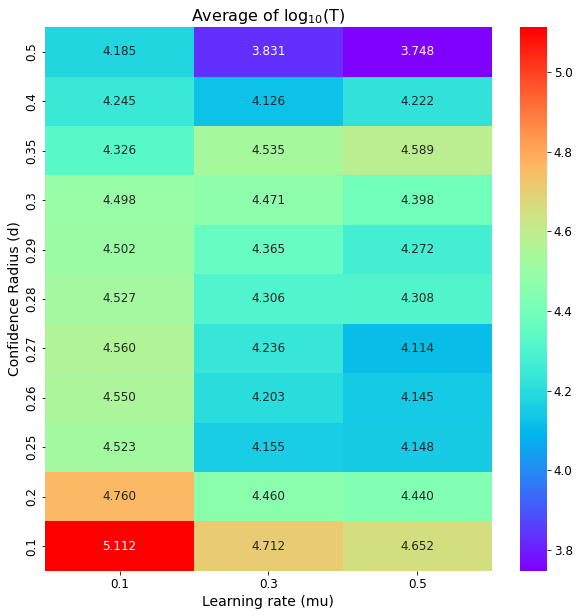

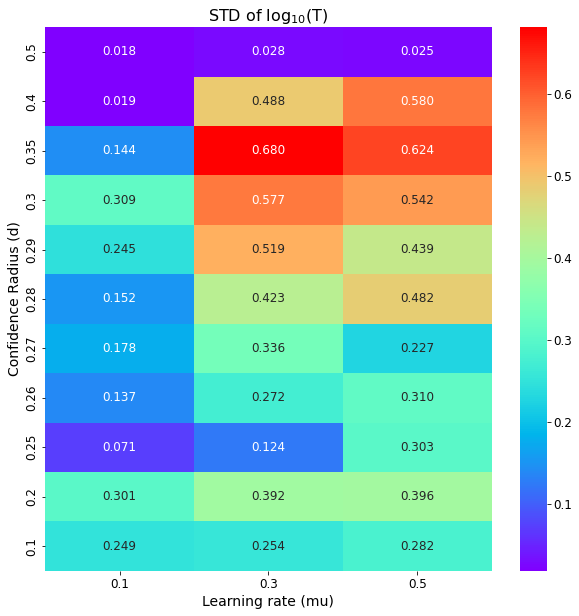

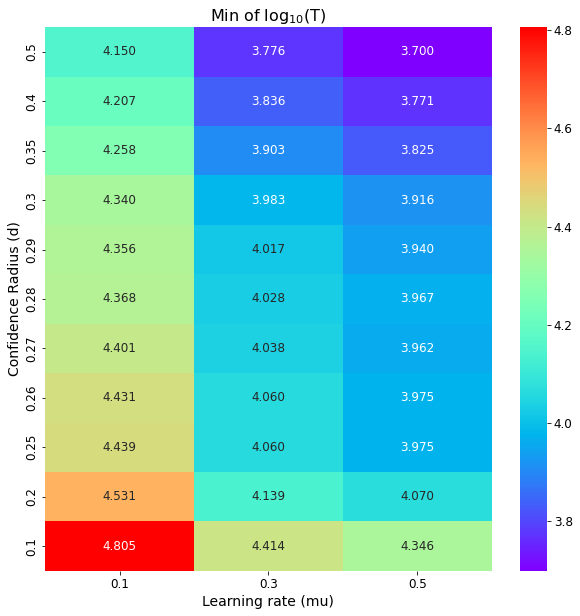

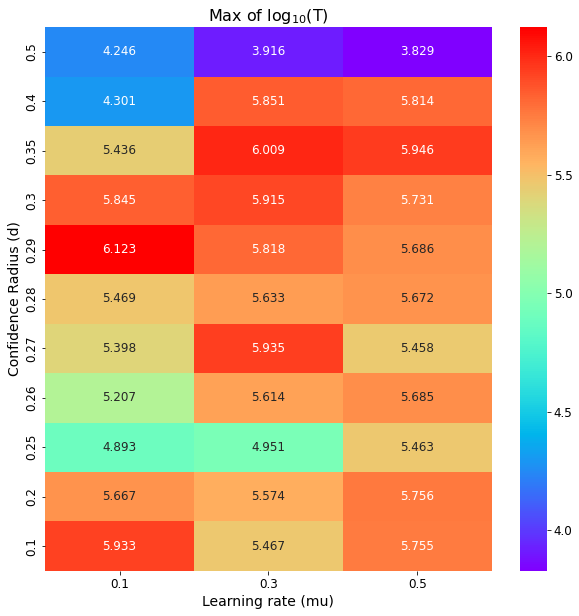

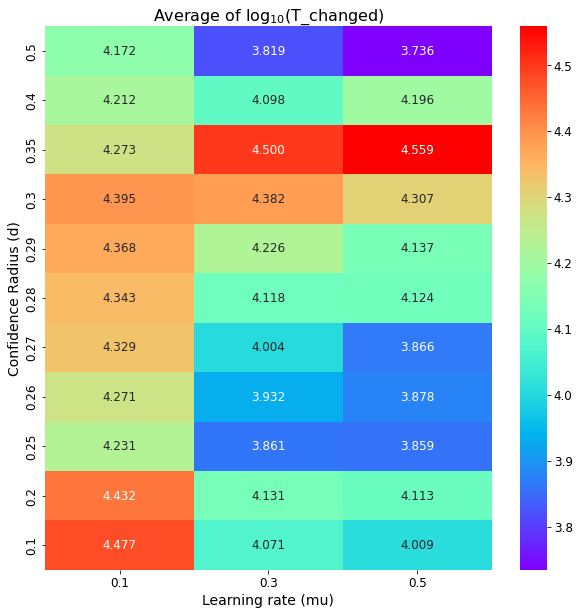

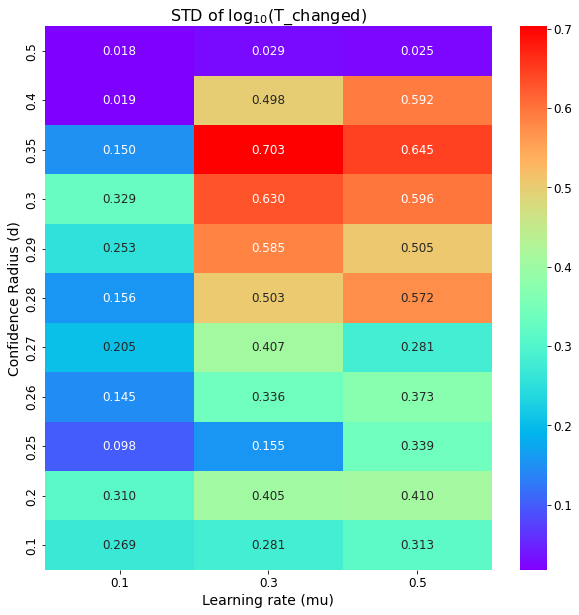

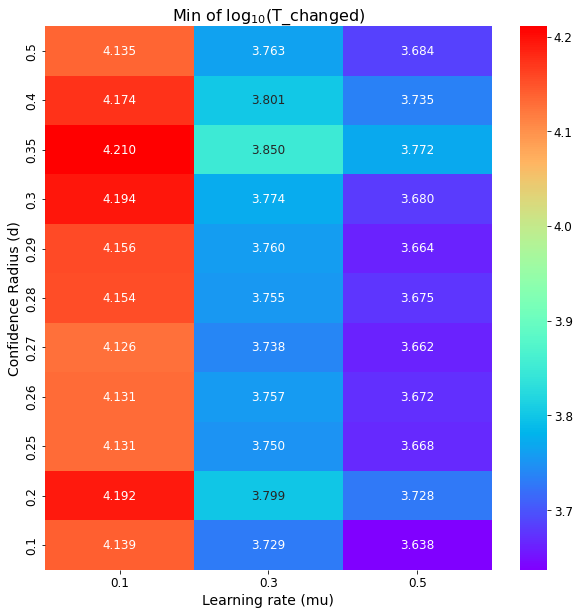

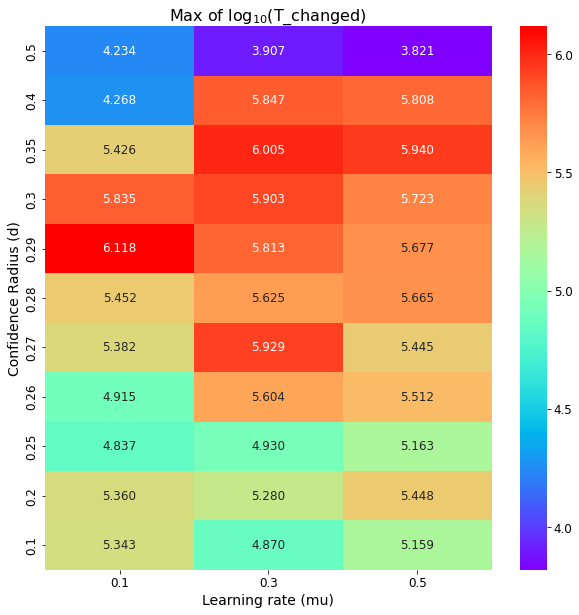

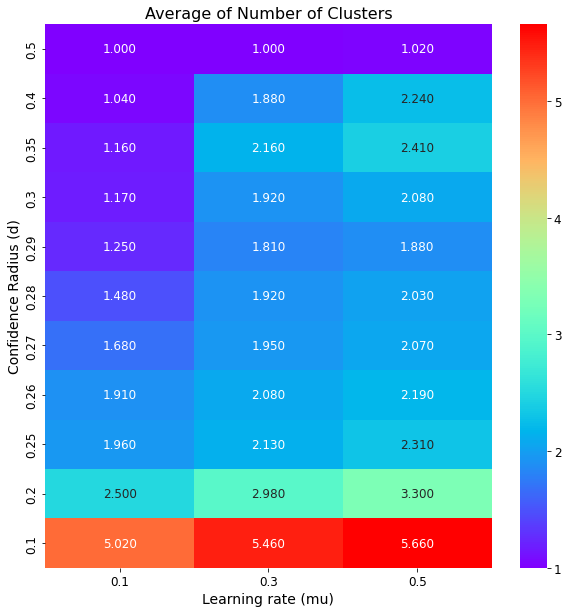

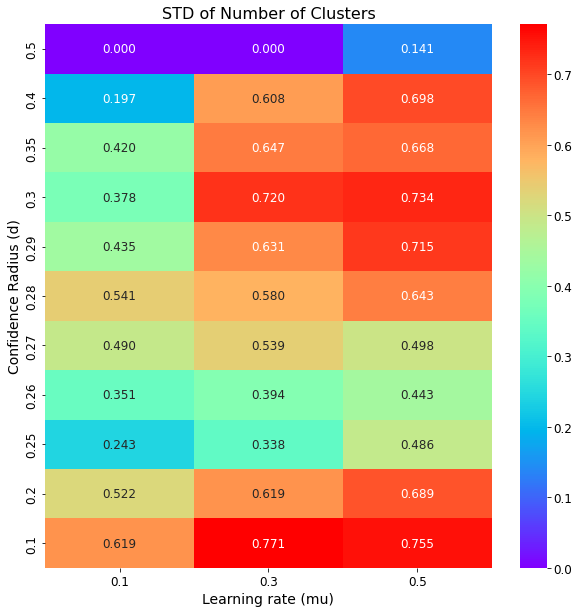

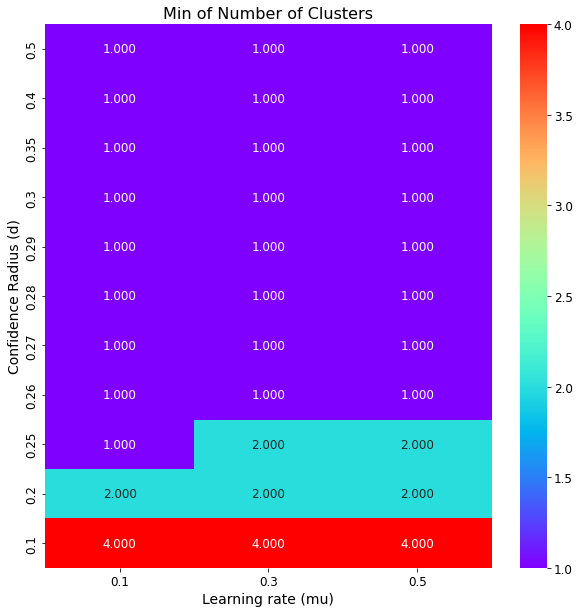

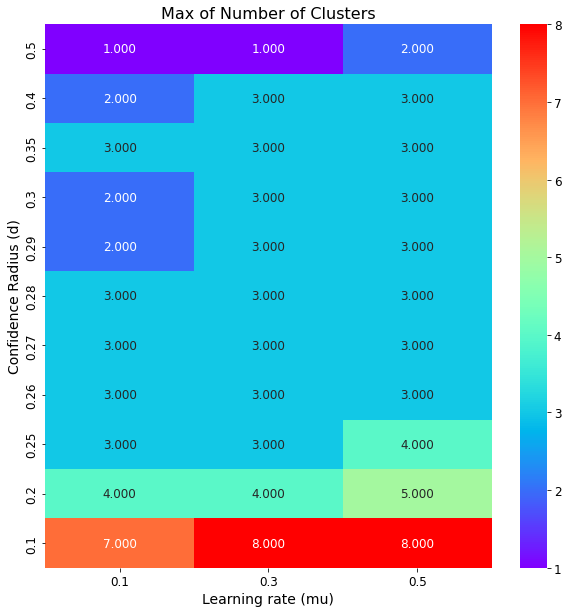

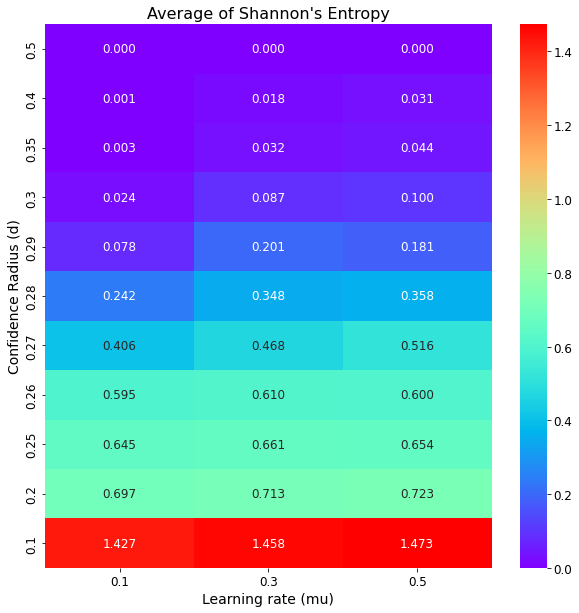

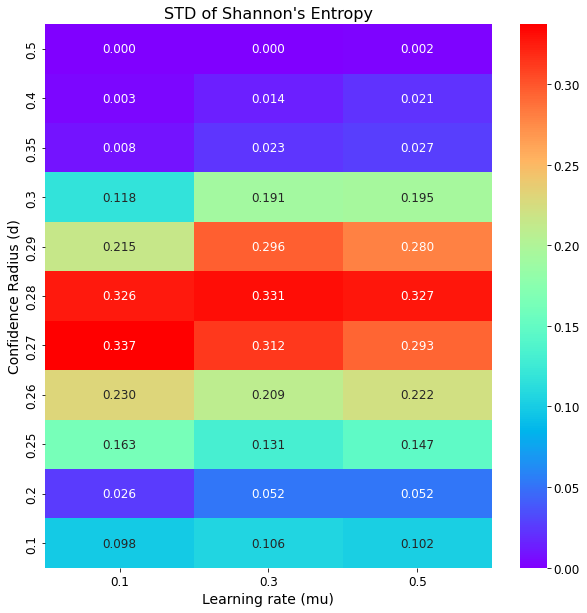

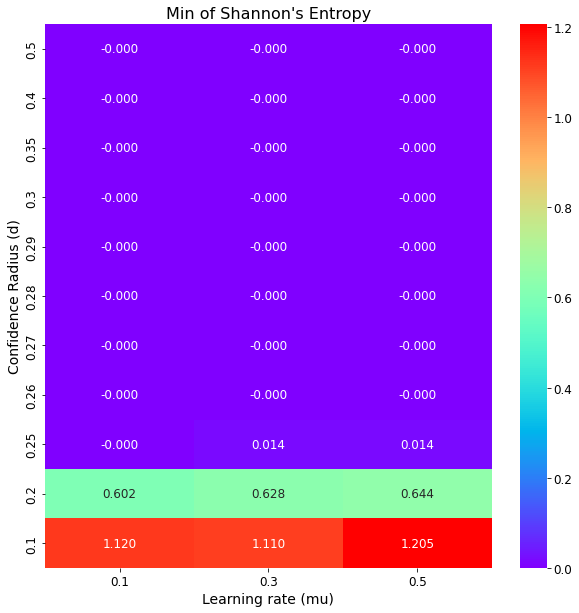

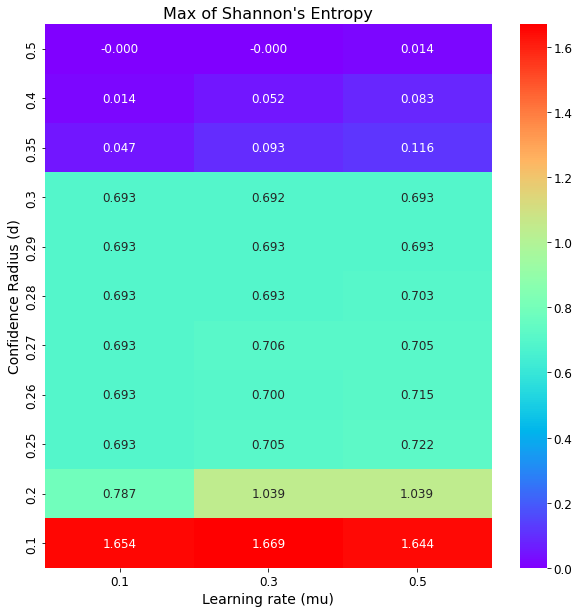

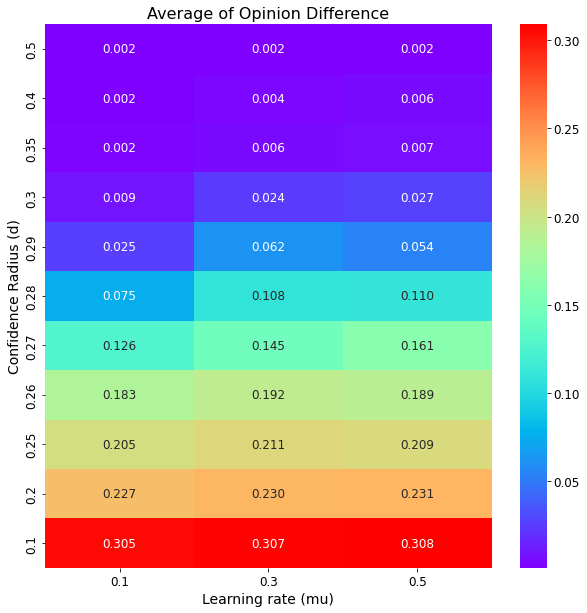

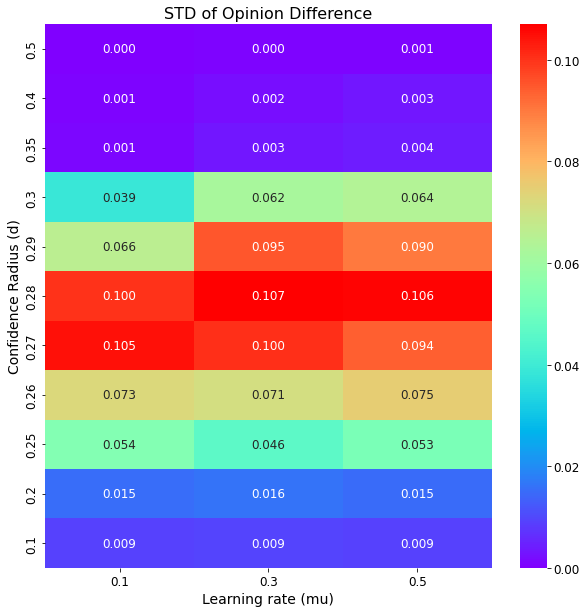

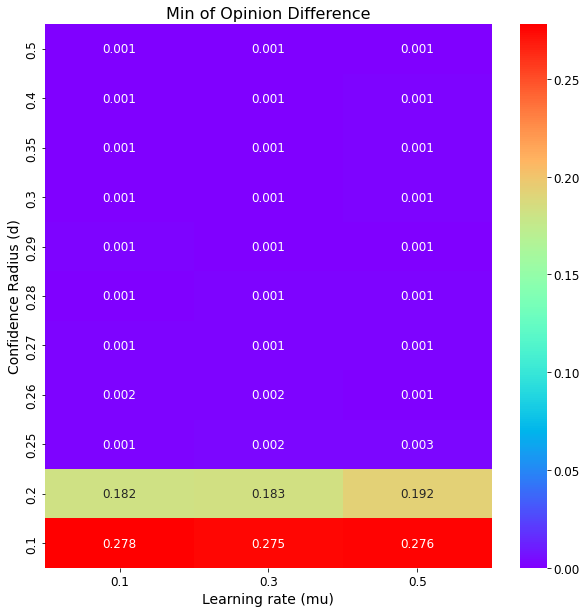

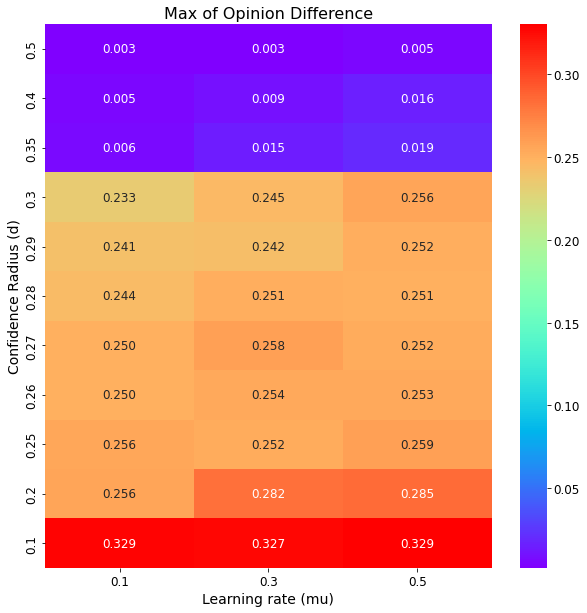

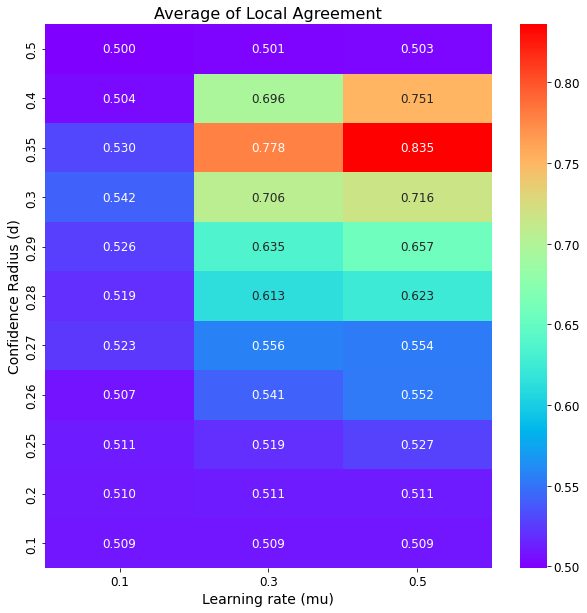

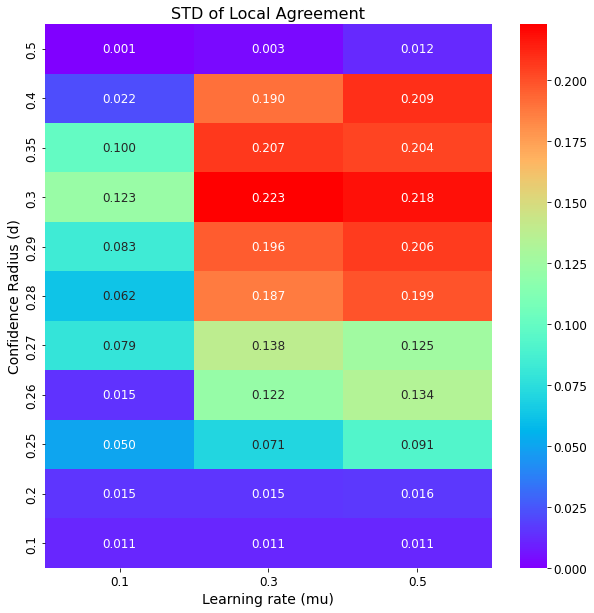

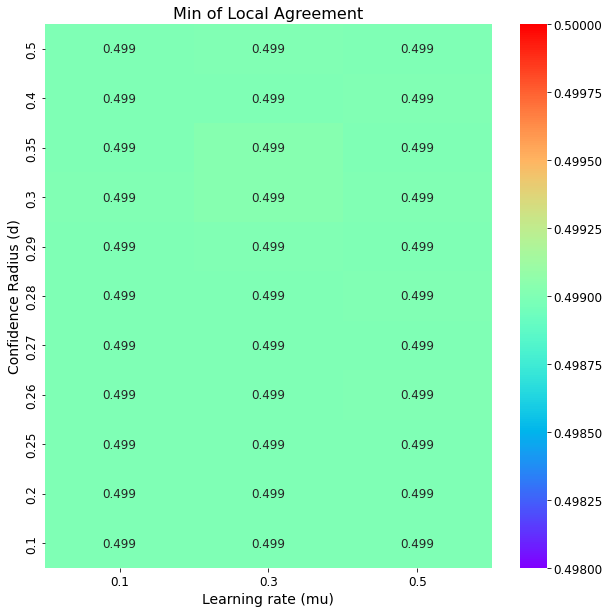

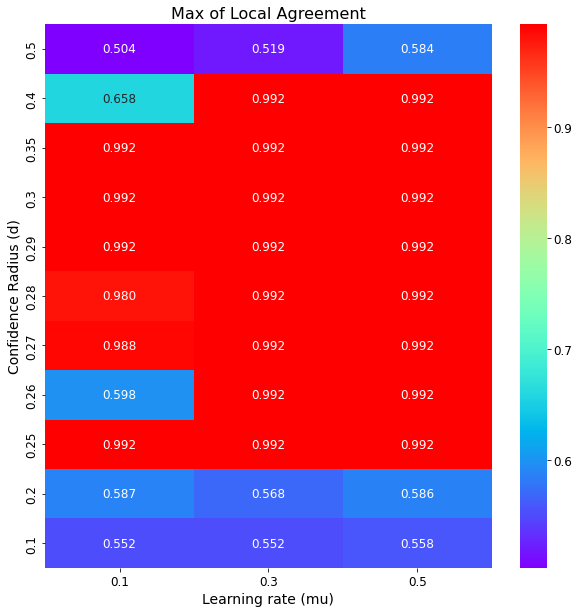

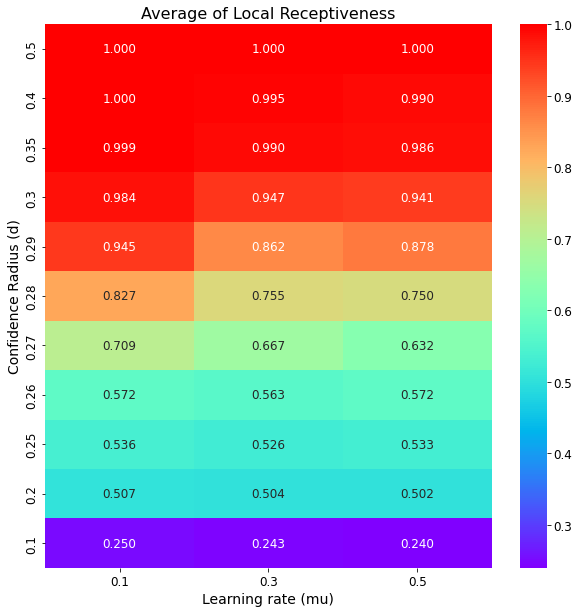

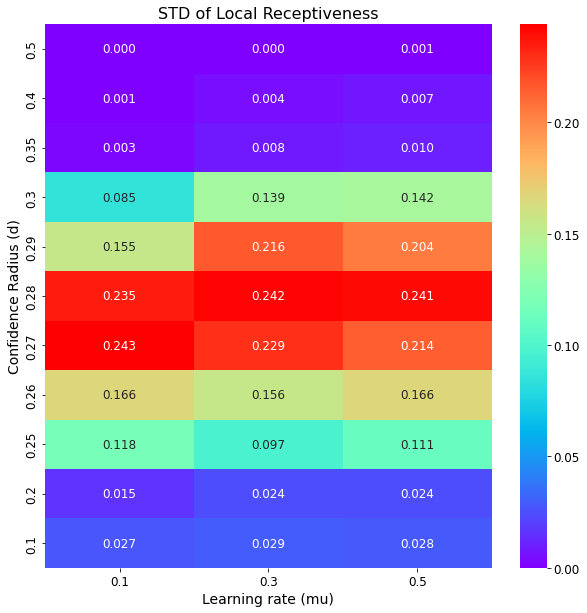

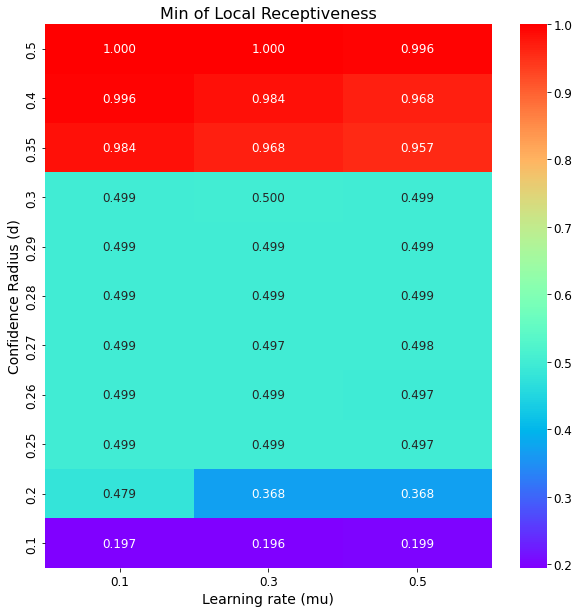

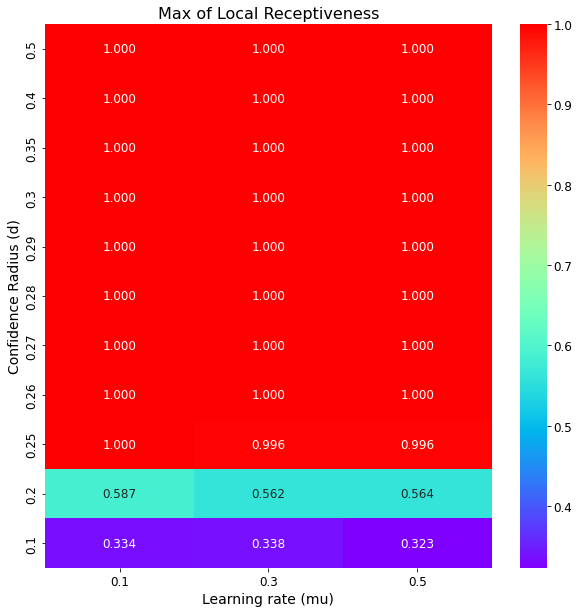

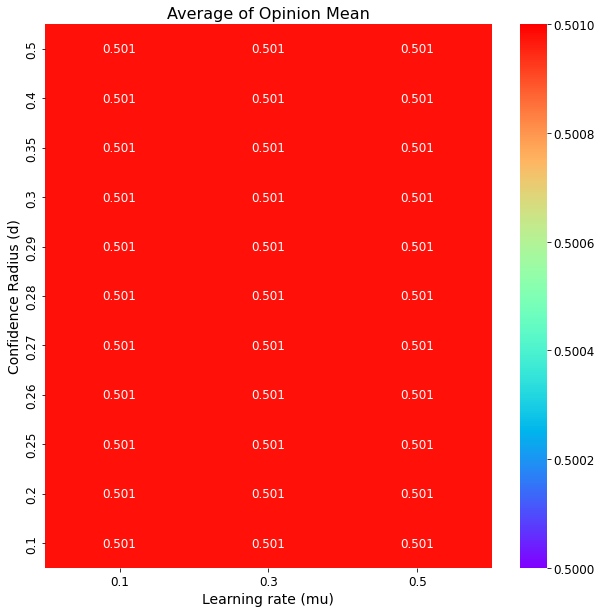

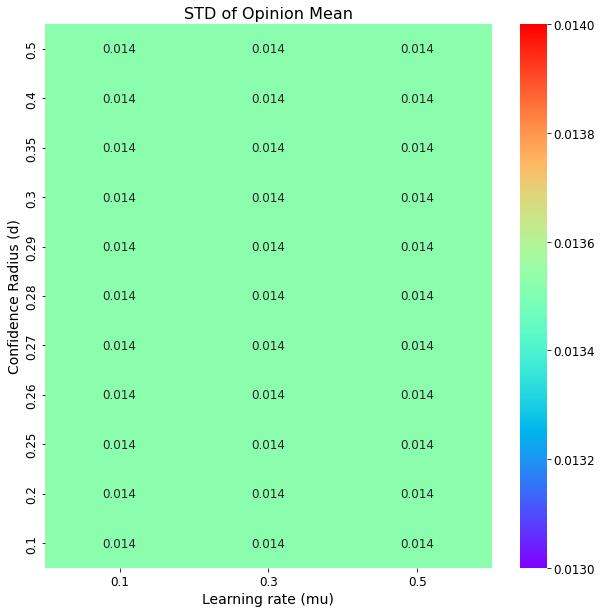

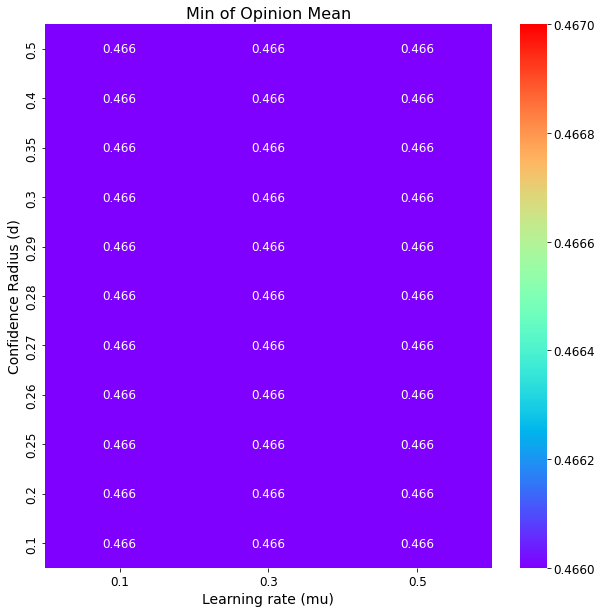

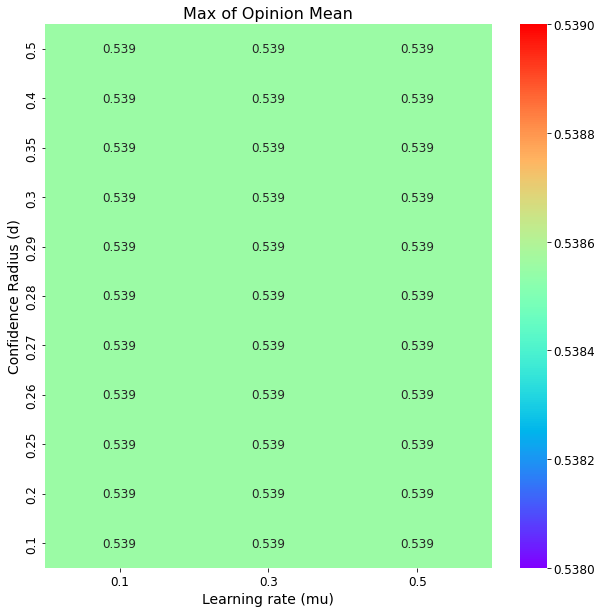

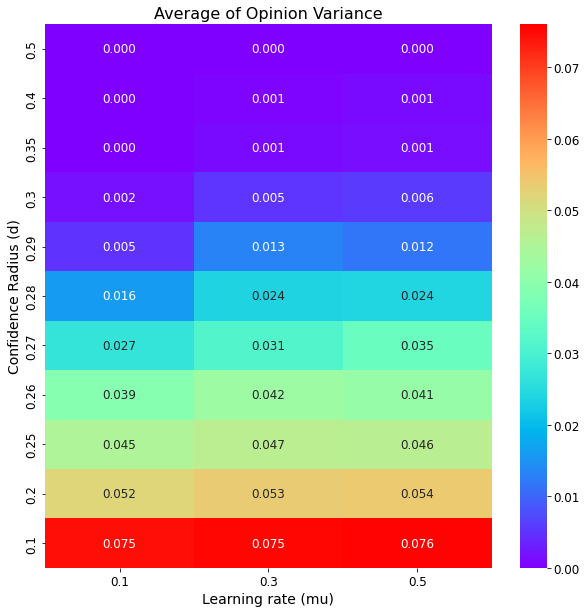

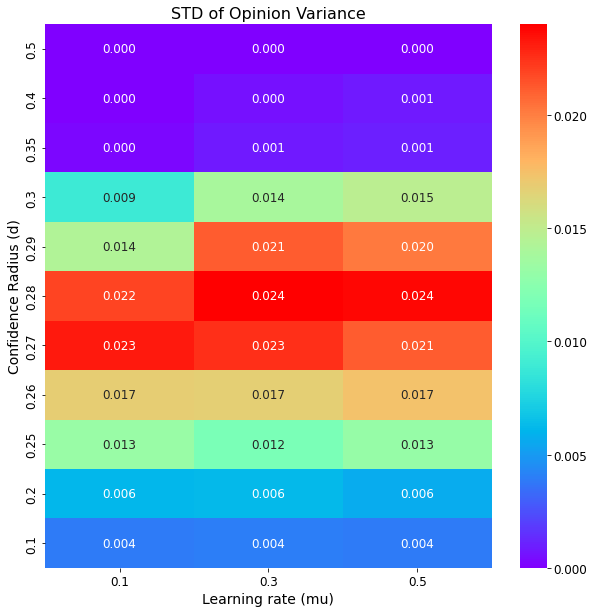

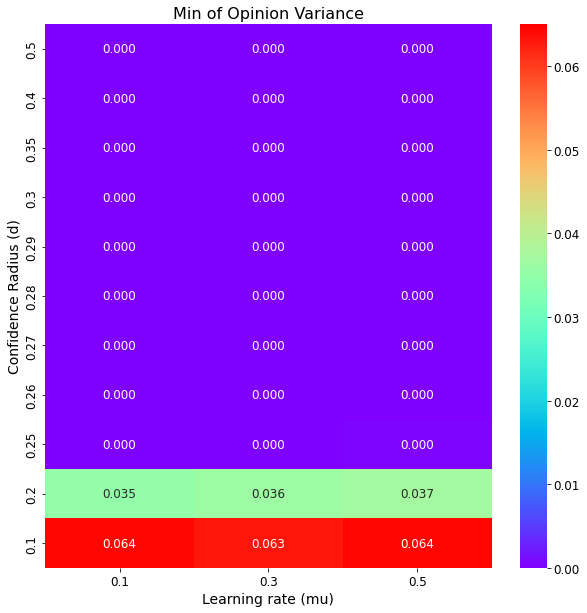

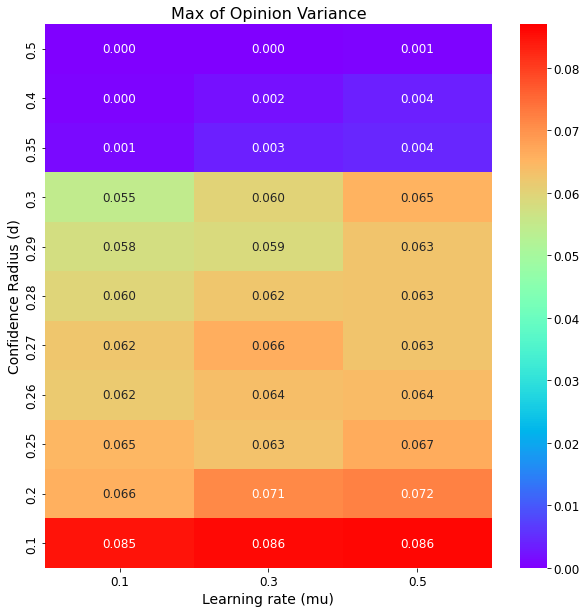

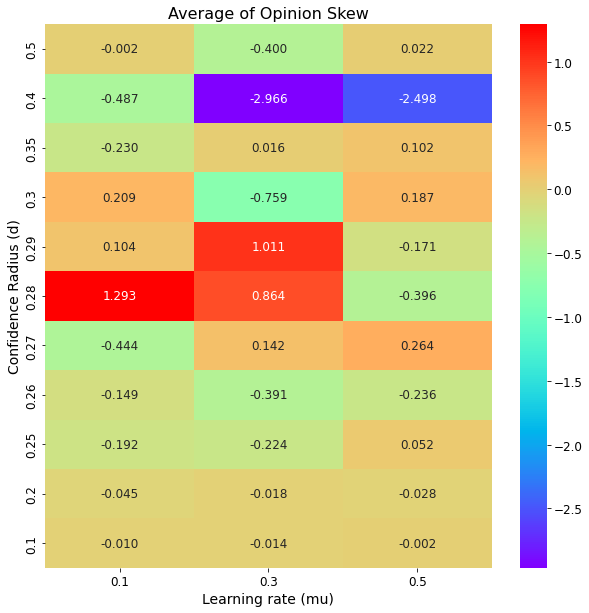

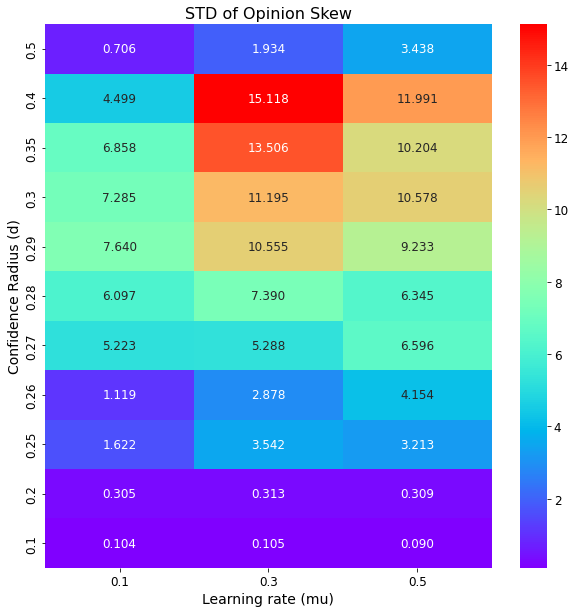

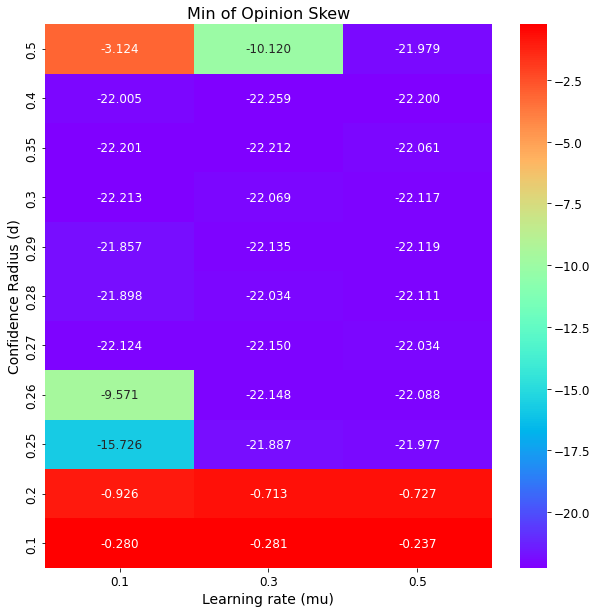

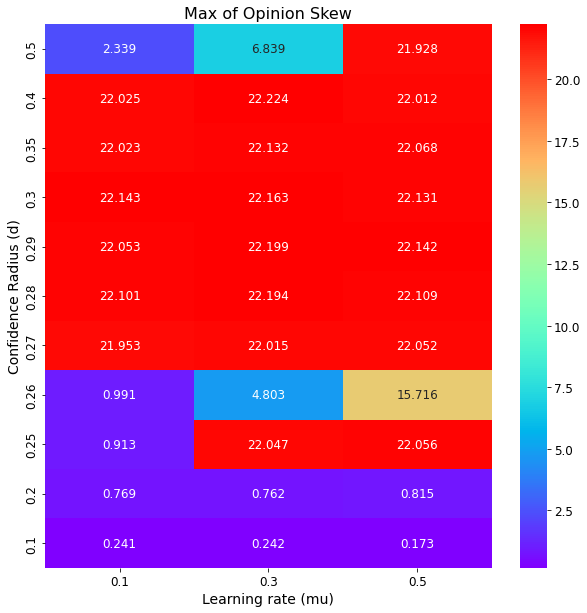

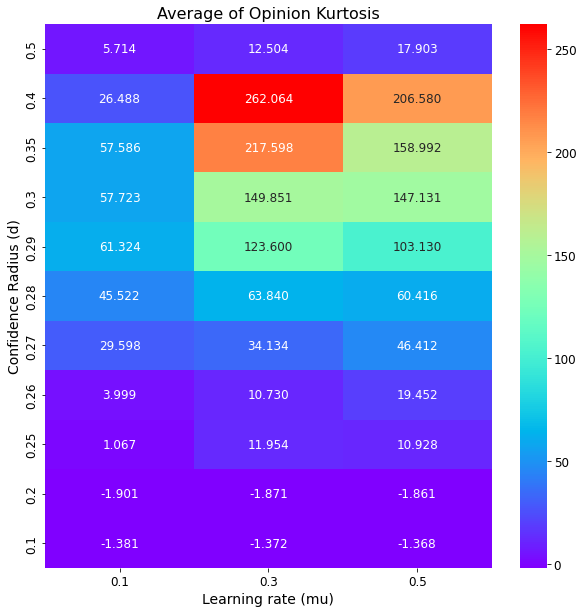

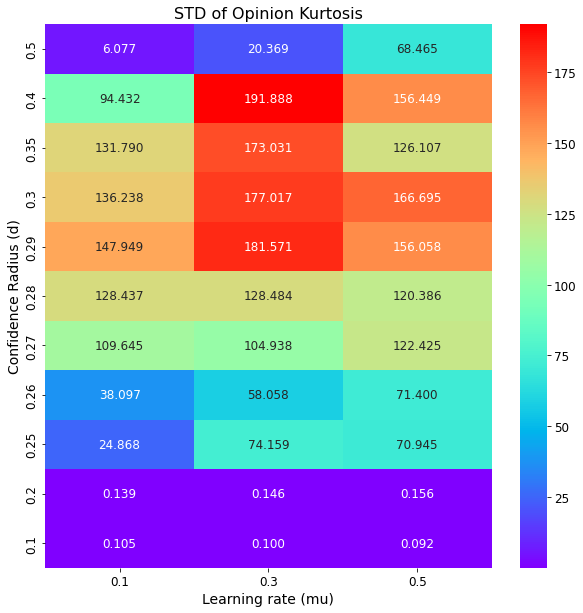

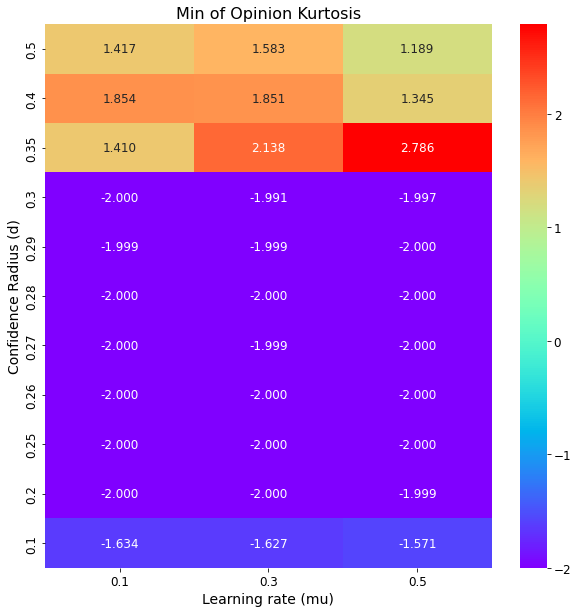

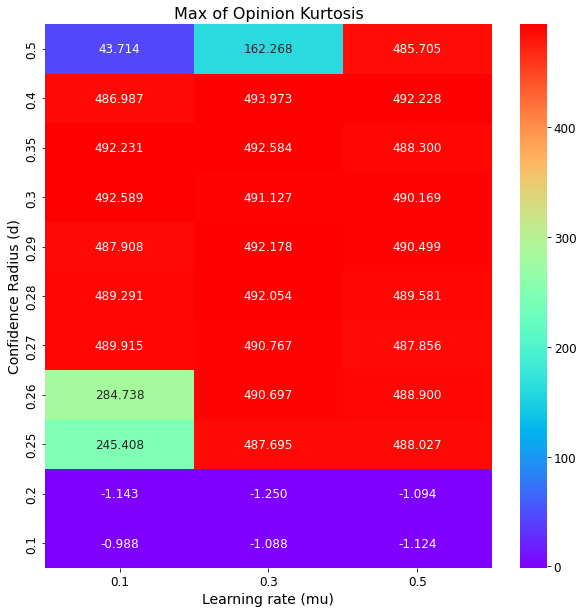

In [7]:
# Plot heat maps of all simulation values

#Should we just generate the average plot?
avg_plot_only = False

#Check that a directory exists, and if not, create it
directories = [experiment + '/plots/heatmaps', experiment + '/plots/heatmaps/other_stats/']
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# We want to consider the graph-level results of :
# convergence time given by log(T), log(T_changed)
# a sense of the opinion clusters with num_cluster, and entropy
# a sense of polarization using avg_opinion_diff, avg_local_agreement, avg_local_receptiveness
# and an understanding of the opinion profile with op_mean, op_var, op_skew, and op_kurtosis
# and their average, variance, max and min

#Define quantities of interest
keys = [
        'log(T)', 'log(T_changed)', 
        'n_clusters', 'entropy',
        'avg_opinion_diff', 
        'avg_local_agreement', 'avg_local_receptiveness',
        'op_mean', 'op_var', 'op_skew', 'op_kurtosis'
       ]
plot_name = {
                'log(T)': 'T', 'log(T_changed)': 'T_changed',
                'n_clusters': 'clusters', 'entropy' : 'entropy',
                'avg_opinion_diff': 'op_diff', 
                'avg_local_agreement' : 'agreement', 
                'avg_local_receptiveness': 'receptiveness',
                'op_mean': 'op_mean', 'op_var': 'op_var', 
                'op_skew': 'op_skew', 'op_kurtosis': 'op_kurtosis'
            }
plot_title = {
                'log(T)': r"$\log_{10}$(T)", 
                'log(T_changed)': r"$\log_{10}$(T_changed)",
                'n_clusters': 'Number of Clusters', 
                'entropy': 'Shannon Entropy',
                'avg_opinion_diff': 'Opinion Difference',
                'avg_local_agreement': 'Local Agreement', 
                'avg_local_receptiveness': 'Local Receptiveness', 
                'op_mean': 'Opinion Mean', 'op_var': 'Opinion Variance', 
                'op_skew': 'Opinion Skew', 'op_kurtosis': 'Opinion Kurtosis'
             }


#Loop through the quantities of interest
for key in keys:

    #Create zero matricies for each heatmap we want to generate
    average, std = np.zeros((len(ds), len(mus))), np.zeros((len(ds), len(mus)))
    minimum, maximum = np.zeros((len(ds), len(mus))), np.zeros((len(ds), len(mus)))

    #Fill in the heatmap values 
    # rows correspond to d
    for row in range(0,len(ds)):
        d = ds[row]

        # columns correspond to mu
        for col in range(0, len(mus)):
            mu = mus[col]
            
            #filter the data table by the d and mu values
            df = sim_results[sim_results['d'] == d]
            df = df[df['mu'] == mu]
            
            #Calculate the descriptive stats
            stats = df[key].describe()
            
            #Add the stats values to the appropriate matrix (heatmap)
            average[row][col] = stats['mean']
            std[row][col] = stats['std']
            minimum[row][col] = stats['min']
            maximum[row][col] = stats['max']
            
    #Plot the heatmaps
    heatmaps = [average, std, minimum, maximum]
    save_suffix = ['_avg', '_std', '_min', '_max']
    title_prefix = ['Average of ', 'STD of ', 'Min of ', 'Max of ']
    
    if avg_plot_only:
        heatmaps = [average]
    
    for i in range(len(heatmaps)):
        heatmap = heatmaps[i]
        savefile = plot_name[key] + save_suffix[i] + "-" + distribution + ".png"
        if save_suffix[i] == "_avg":
            savefile = experiment + "/plots/heatmaps/" + savefile
        else:
            savefile = experiment + "/plots/heatmaps/other_stats/" + savefile
        DW.plot_heatmap(heatmap, ds=ds, mus=mus, show_values = True, decimal_places = 3, title = title_prefix[i] + plot_title[key], savefile = savefile)
        if save_suffix[i] != "_avg":
            plt.close()

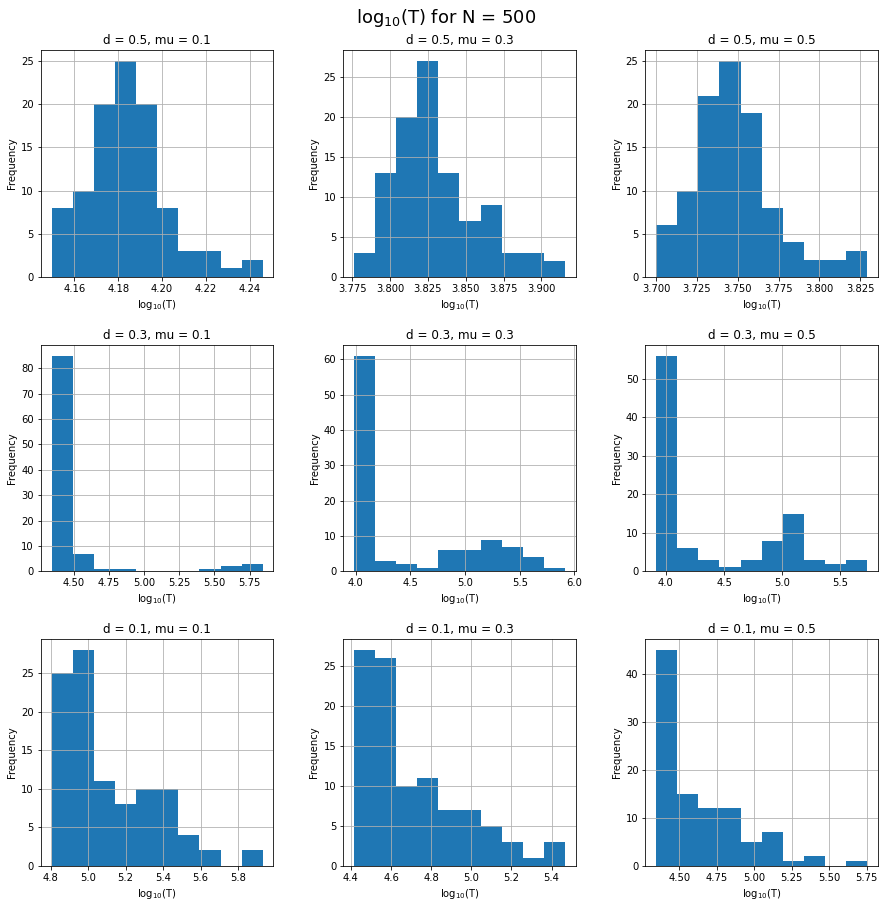

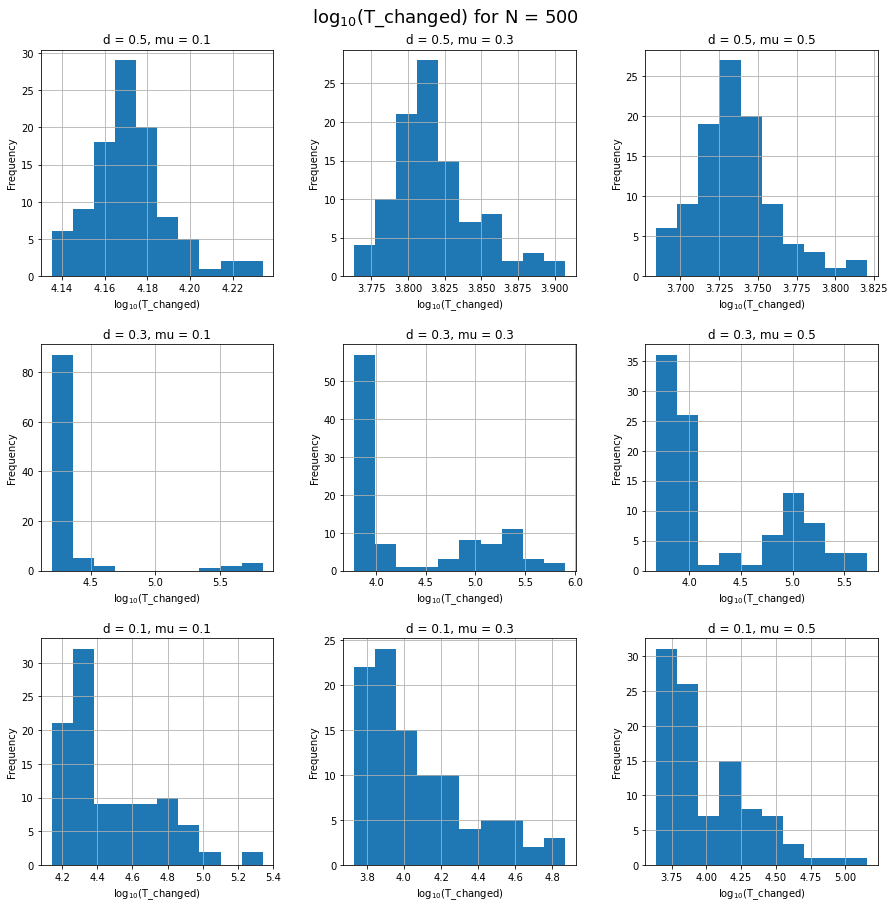

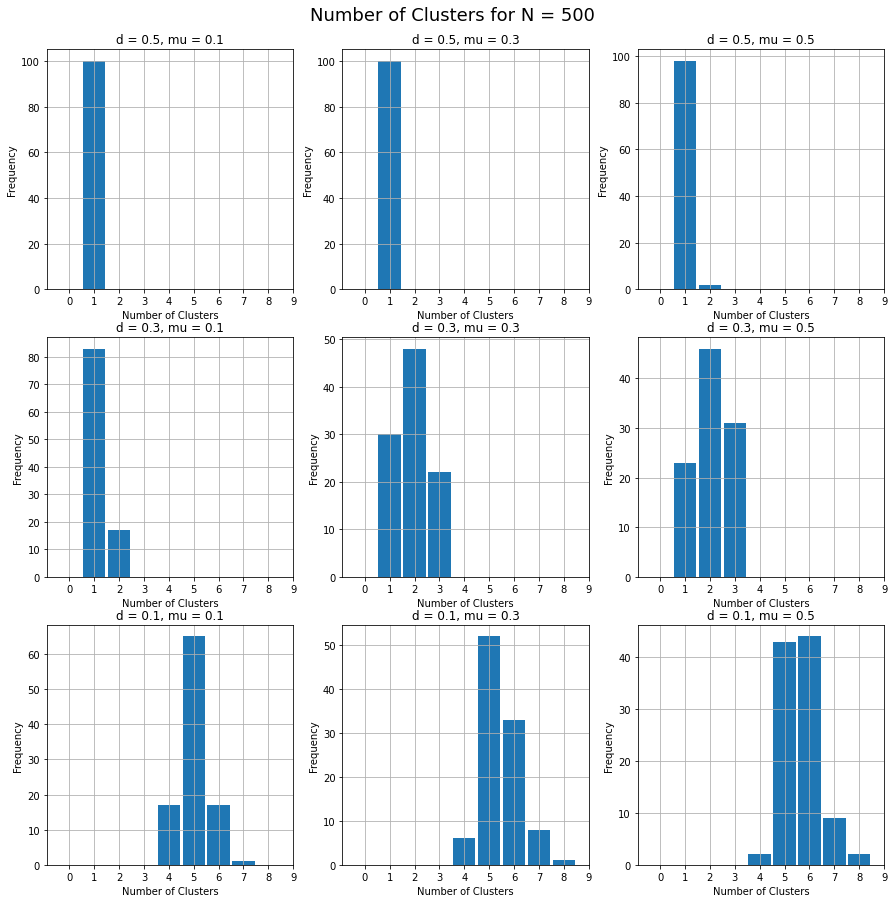

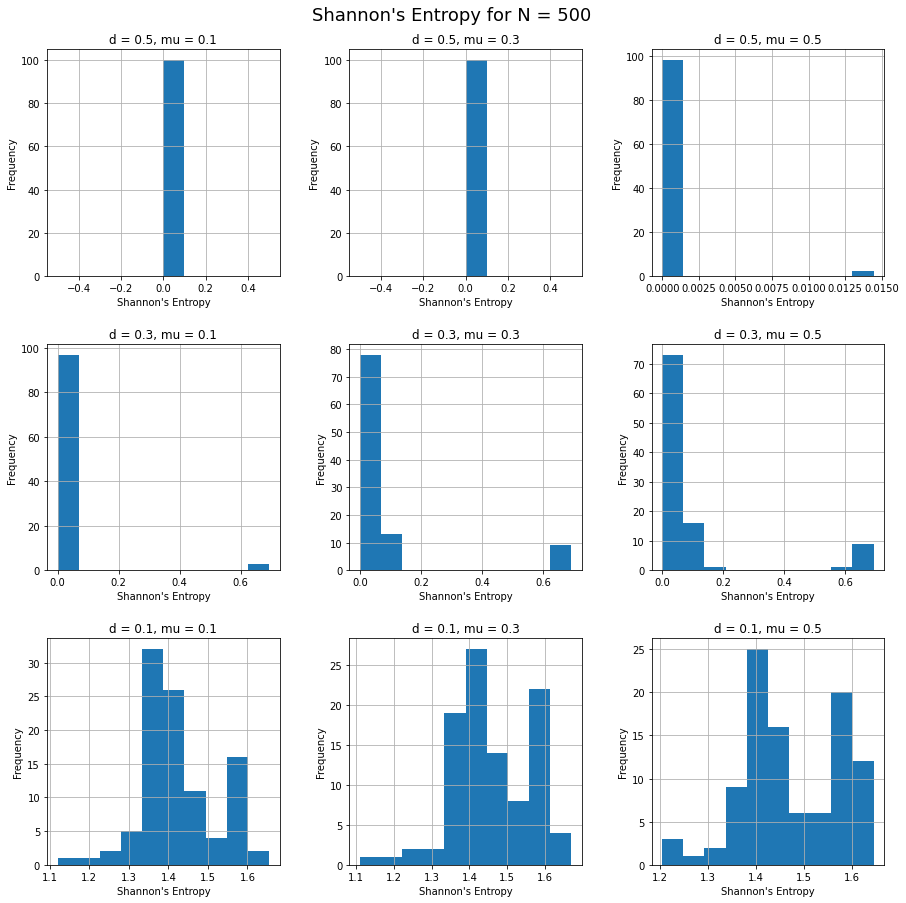

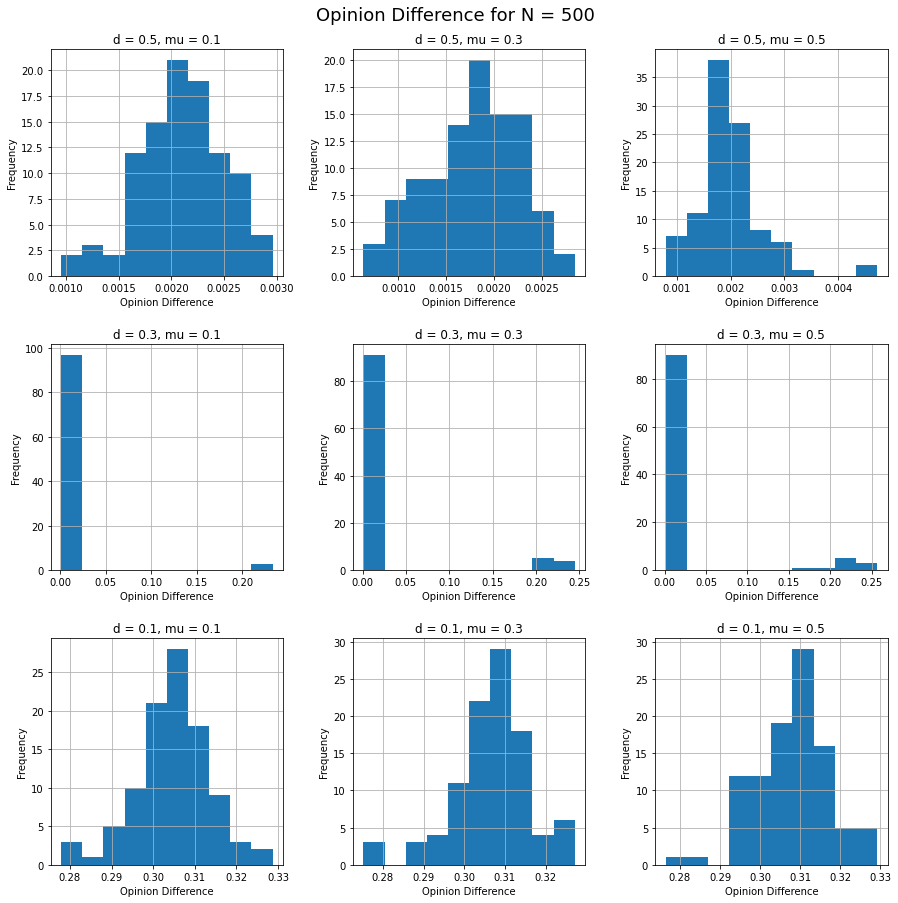

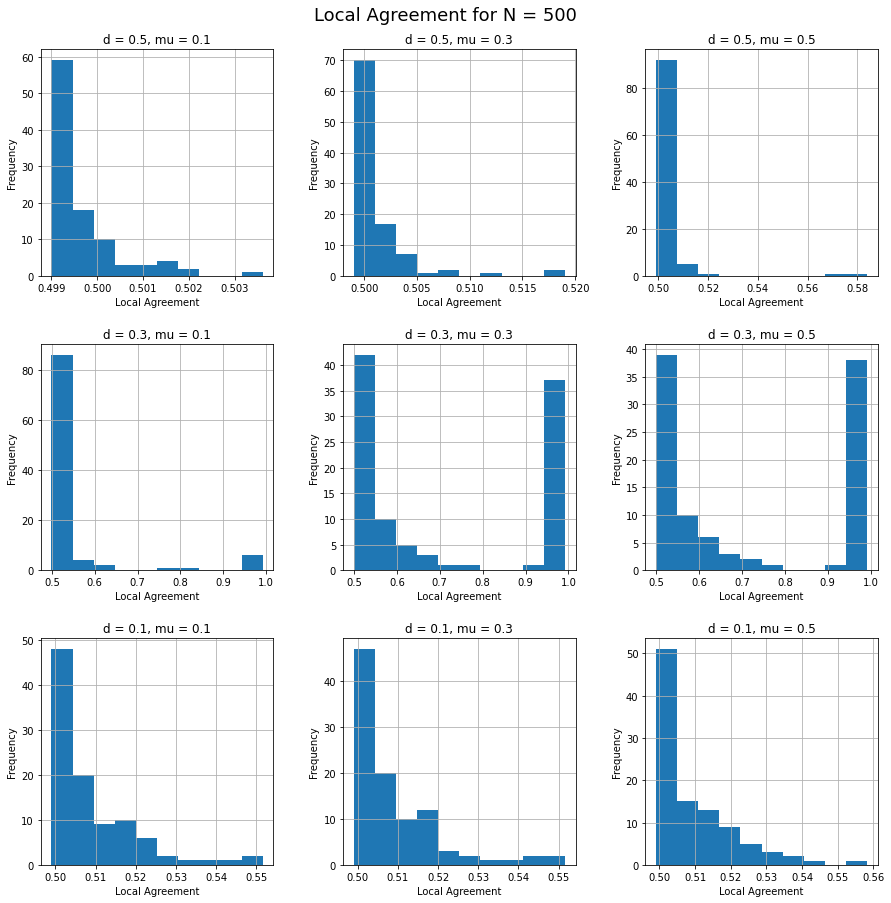

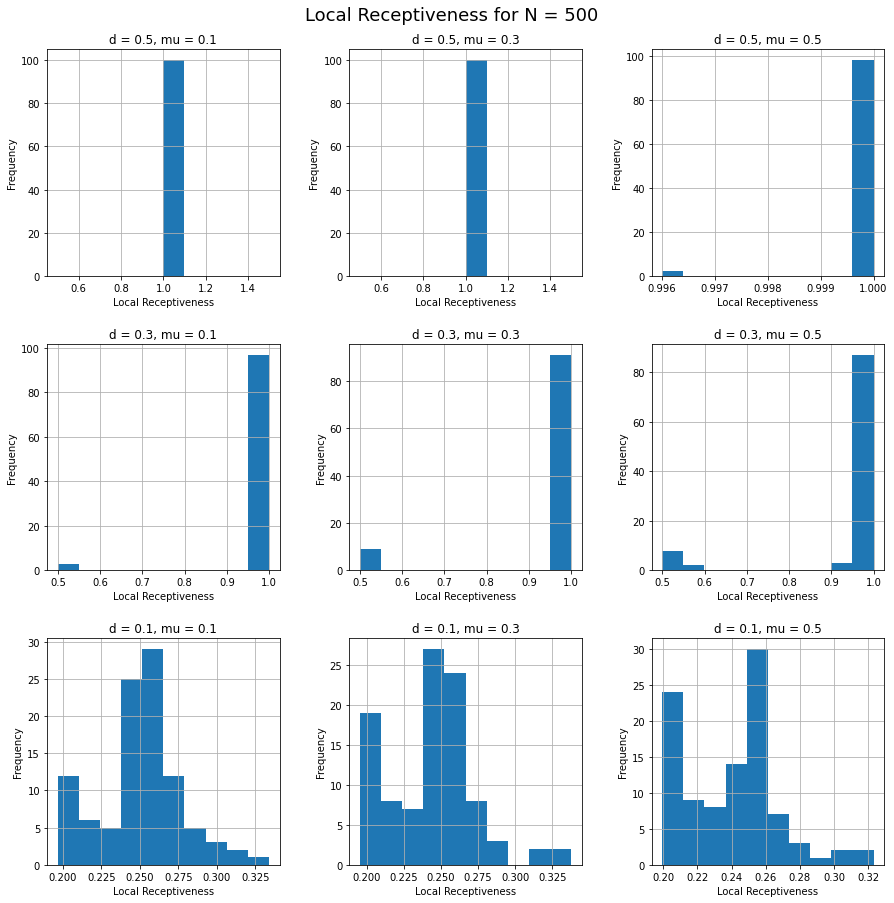

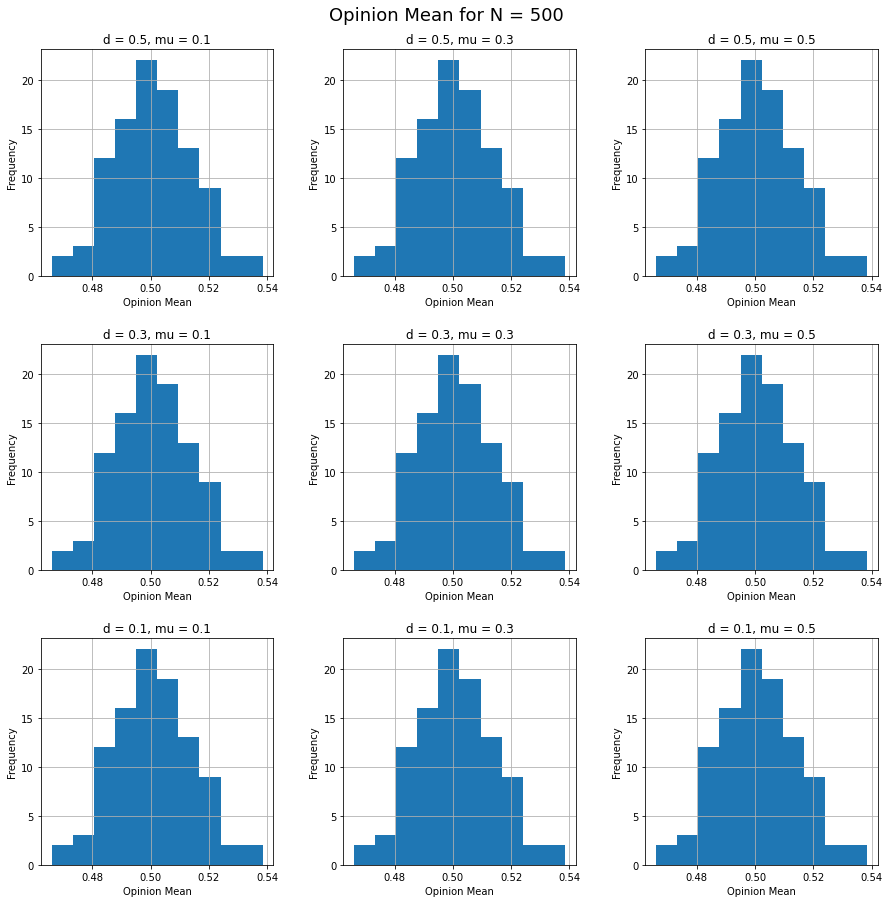

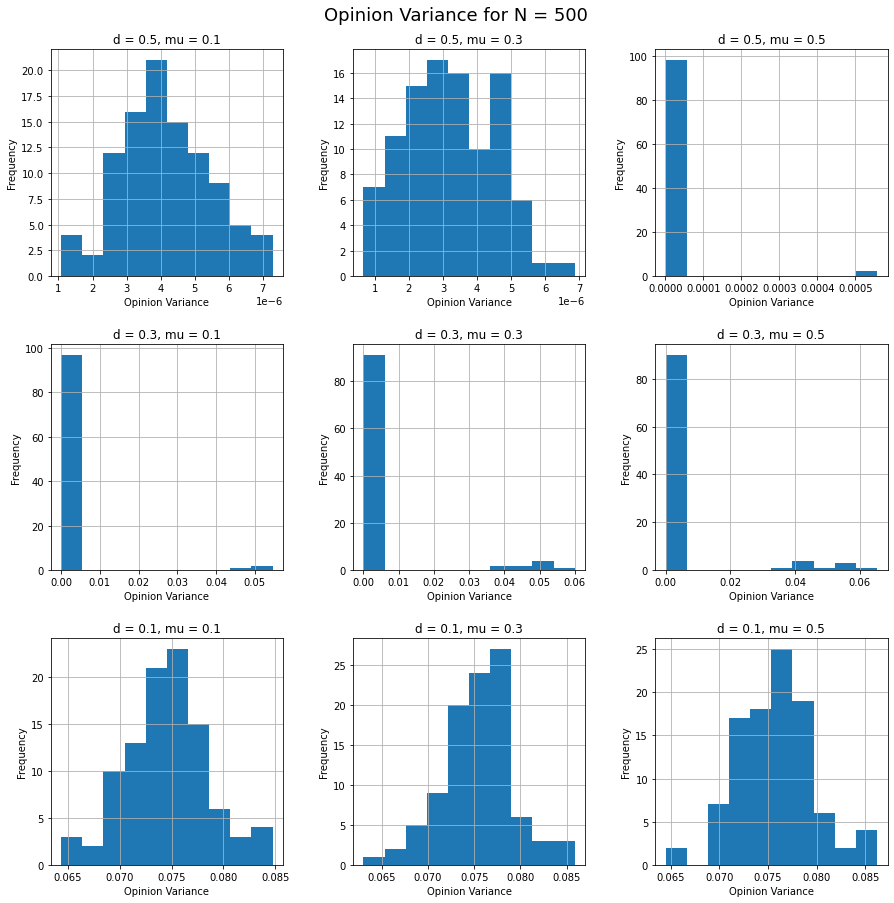

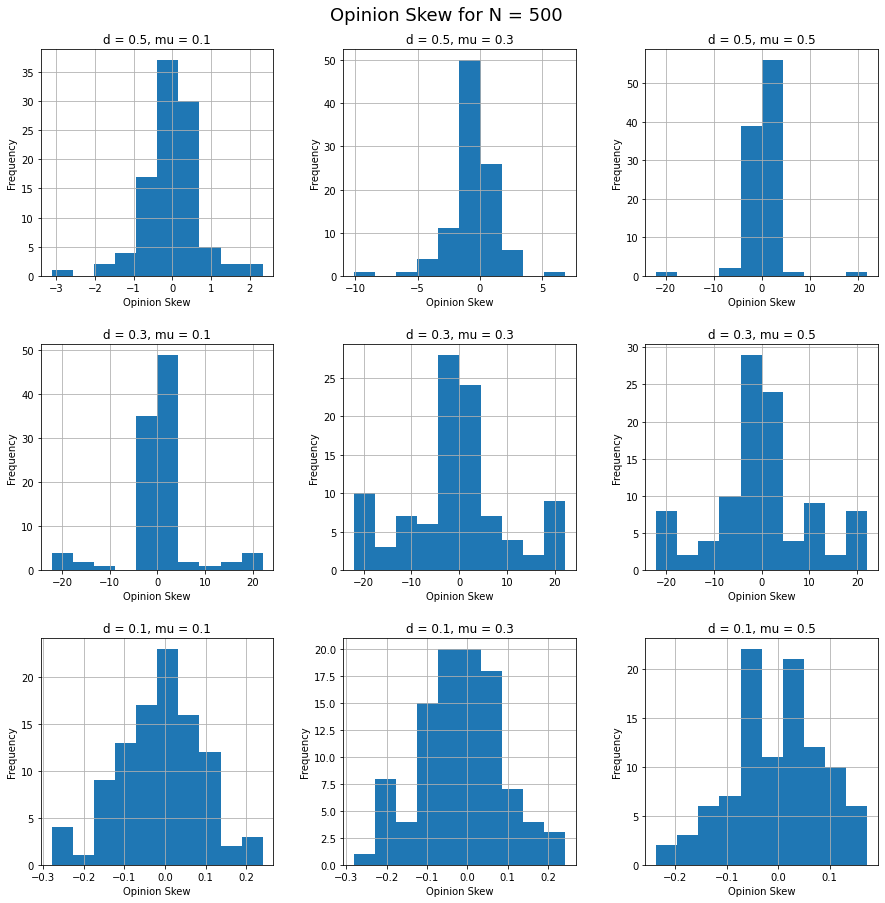

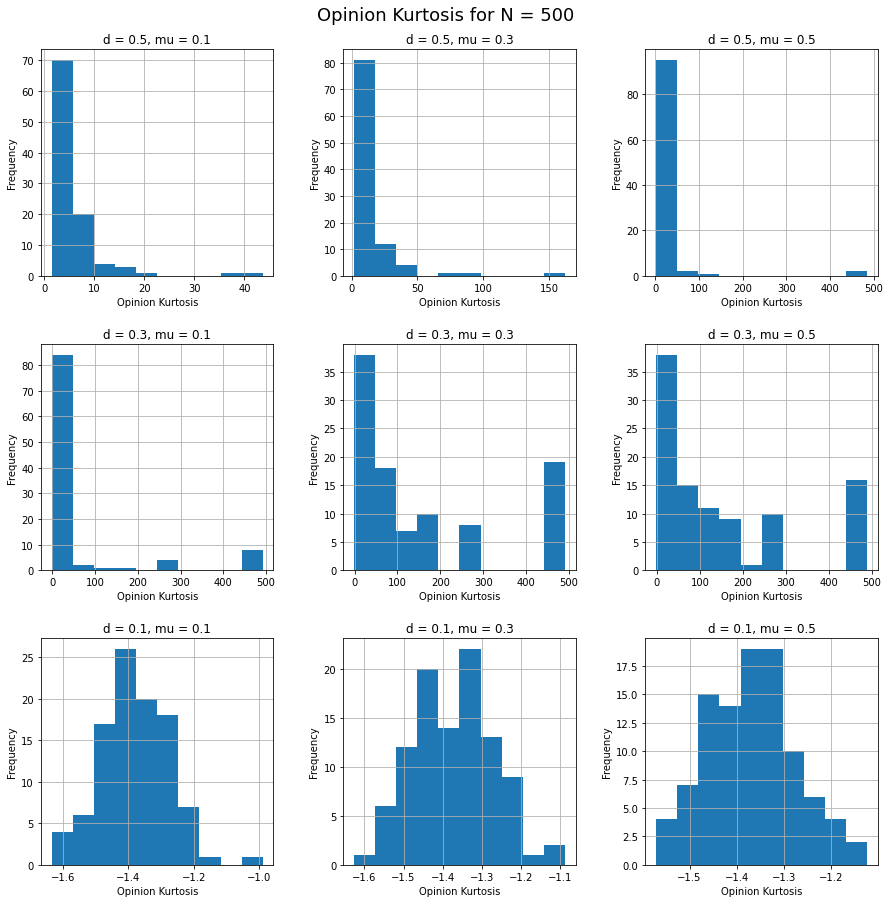

In [8]:
# Plot histogram of various values for each d and mu pair

#Check that a directory exists, and if not, create it
directory = experiment + "/plots/histograms/"
if not os.path.exists(directory):
    os.makedirs(directory)
    
#Define quantities of interest
keys = ['log(T)', 'log(T_changed)', 
        'n_clusters', 'entropy',
        'avg_opinion_diff', 
        'avg_local_agreement', 'avg_local_receptiveness',
        'op_mean', 'op_var', 'op_skew', 'op_kurtosis']
plot_name = {
                'log(T)': 'T', 'log(T_changed)': 'T_changed',
                'n_clusters': 'clusters', 'entropy' : 'entropy',
                'avg_opinion_diff': 'op_diff', 
                'avg_local_agreement' : 'agreement', 
                'avg_local_receptiveness': 'receptiveness',
                'op_mean': 'op_mean', 'op_var': 'op_var', 
                'op_skew': 'op_skew', 'op_kurtosis': 'op_kurtosis'
            }
plot_title = {
                'log(T)': r"$\log_{10}$(T)", 
                'log(T_changed)': r"$\log_{10}$(T_changed)",
                'n_clusters': 'Number of Clusters', 
                'entropy': 'Shannon\'s Entropy',
                'avg_opinion_diff': 'Opinion Difference',
                'avg_local_agreement': 'Local Agreement', 
                'avg_local_receptiveness': 'Local Receptiveness', 
                'op_mean': 'Opinion Mean', 'op_var': 'Opinion Variance', 
                'op_skew': 'Opinion Skew', 'op_kurtosis': 'Opinion Kurtosis'
             }

#Get the maximum number of clusters for plotting the integer-binned histogram
df = sim_results[sim_results['d'].isin(hist_ds)]
df = df[df['mu'].isin(hist_mus)]
max_clusters = max(df["n_clusters"])

#Loop through the quantities of interest
for key in keys:
    # Create new plot
    rows, cols = len(hist_ds), len(hist_mus)
    fig, axs = plt.subplots(rows, cols, figsize = (5*cols, 5*rows), facecolor='white')
    
    #Loop through each d and mu combo    
    for row in range(len(hist_ds)):
        d = hist_ds[row]
        for col in range(len(hist_mus)):
            mu = hist_mus[col]
            ax = axs[row, col]

            #filter the data table by the d and mu values
            df = sim_results[sim_results['d'] == d]
            df = df[df['mu'] == mu]

            #Plot the histogram
            if key == "n_clusters":
                df["n_clusters"] = df["n_clusters"].fillna(0)
                #array = np.array(df["n_clusters"], dtype=np.int64)
                bins = np.arange(0, max_clusters + 1.5) - 0.5
                df["n_clusters"].hist(ax=ax, bins=bins, rwidth=0.9)
                ax.set_xticks(bins+0.5)
            else:
                df.hist(column = key, ax = ax, sharex=True, sharey= True)
            ax.set_xlabel(plot_title[key])
            ax.set_ylabel("Frequency")
            ax.set_title("d = " + str(d) + ", mu = " + str(mu))
            
    plt.suptitle(plot_title[key] + " for N = " + str(n),
                y = 0.92, fontsize = 18)
    savefile = experiment + "/plots/histograms/" + plot_name[key] + "_hist-" + distribution + ".png"
    plt.savefig(savefile, bbox_inches = "tight")
